In [1]:
# %%
import os
import glob
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat

In [2]:
#%%
df=pd.read_csv('C:/workspace_python/study/data_plus/10min/ONTUNE2016.csv')
df['new_Date']=pd.to_datetime(df['date'])
df.head()


,Unnamed: 0,date,value,new_Date
0,0,2020-03-28 09:00:00,16,2020-03-28 09:00:00
1,1,2020-03-28 09:10:00,9,2020-03-28 09:10:00
2,2,2020-03-28 09:20:00,9,2020-03-28 09:20:00
3,3,2020-03-28 09:30:00,9,2020-03-28 09:30:00
4,4,2020-03-28 09:40:00,9,2020-03-28 09:40:00


In [3]:

New=df[['value']]  #시간과 real_free 만 뽑아서 새로운 데이터 프레임
New.index=df['new_Date']
New.head()

,value
new_Date,
2020-03-28 09:00:00,16
2020-03-28 09:10:00,9
2020-03-28 09:20:00,9
2020-03-28 09:30:00,9
2020-03-28 09:40:00,9


In [4]:
#스케일링 하는 함수 생성
def series_to_superised(data,n_in=1,n_out=1,dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df=pd.DataFrame(data)
    cols,names=list(),list()
  
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names +=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]

    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)'%(j+1,i)) for j in range(n_vars)]
  
    agg=concat(cols,axis=1)
    agg.columns=names

    if dropnan:
        agg.dropna(inplace=True)
  
    return agg

In [5]:
#주어진 데이터 정규화, 스케일링
values = globals()['New'].values
values_1 = values.reshape(-1,1)

#minmax scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values_1)

#300개의 이전 데이터로 144개의 데이터 예측->1일치 데이터 예측
a=300
b=144

reframed = series_to_superised(scaled, a, b)
values_2 = reframed.values


In [6]:
#train 데이터, test 데이터 분리
n_train_days = int(values_2.shape[0] * 0.9)
train = values_2[:n_train_days, :]
test = values_2[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-b], train[:, -b:]
test_X, test_y = test[:, :-b], test[:, -b:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(46408, 1, 300) (46408, 144) (5157, 1, 300) (5157, 144)


In [7]:
#lstm 모델 생성
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(128,return_sequences=False))
#model.add(Dense(50,activation='relu'))
#model.add(Dense(16,activation='relu'))
model.add(Dense(b))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Epoch 1/10
726/726 [==============================] - 41s 33ms/step - loss: 0.0516 - val_loss: 0.0442
Epoch 2/10
726/726 [==============================] - 10s 13ms/step - loss: 0.0472 - val_loss: 0.0271
Epoch 3/10
726/726 [==============================] - 9s 12ms/step - loss: 0.0409 - val_loss: 0.0370s 
Epoch 4/10
726/726 [==============================] - 9s 12ms/step - loss: 0.0394 - val_loss: 0.0336
Epoch 5/10
726/726 [==============================] - 9s 13ms/step - loss: 0.0382 - val_loss: 0.0362
Epoch 6/10
726/726 [==============================] - 10s 13ms/step - loss: 0.0378 - val_loss: 0.0379
Epoch 7/10
726/726 [==============================] - 10s 14ms/step - loss: 0.0370 - val_loss: 0.0416
Epoch 8/10
726/726 [==============================] - 9s 13ms/step - loss: 0.0377 - val_loss: 0.0395
Epoch 9/10
726/726 [==============================] - 10s 14ms/step - loss: 0.0375 - val_loss: 0.0370
Epoch 10/10
726/726 [==============================] - 9s 12ms/step - loss: 0.0360 -

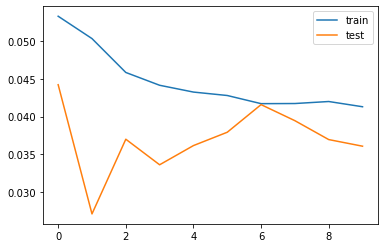

In [8]:
# plot history 그리기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
#test_X 부분을 예측모델을 통해 예측
yhat=model.predict(test_X)


In [10]:
#test 부분 예측 값 중복 제거하여 정리
y_hat=[]
test_yf=[]
k=len(test_X)//144
for i in range(0,k):
    yhat3 = np.array(yhat[i*144]).flatten().tolist()
    y_hat=y_hat+yhat3
    test_y2=np.array(test_y[i*144]).flatten().tolist()
    test_yf=test_yf+test_y2

In [11]:
yhat2=yhat.flatten().tolist()
y_hat_f=y_hat+yhat2[-117:]
test_y5=test_y.flatten().tolist()
test_y_f=test_yf+test_y5[-117:]


In [12]:
#y_hat_f, test_y_f 를 inverse 하여 원래의 값 도출하여 rmse 구함
y_hat_f_i=np.array(y_hat_f).reshape(1,-1)
test_y_f_i=np.array(test_y_f).reshape(1,-1)
yhat_inver=scaler.inverse_transform(y_hat_f_i)
test_y_inver=scaler.inverse_transform(test_y_f_i)

rmse=np.sqrt(np.mean(yhat_inver-test_y_inver)**2)
print('RMSE: '+str(rmse))

RMSE: 0.2803152442875646


In [13]:
#최근 데이터 300개 가져와서 정규화
last_100_10min=New.values
last_300_scaled=scaler.transform(New[-300:].values)

#과거 300일치 데이터 붙여줌
X_test=[]
X_test.append(last_300_scaled)
X_test=np.array(X_test)

#모델 돌리기위해 reshape
X_test=np.reshape(X_test,(1,1,test_X.shape[2]))

#주어진 전체 데이터 이후의 1일치(144개 데이터) 예측하기
pred_price=model.predict(X_test)
pred_price=scaler.inverse_transform(pred_price)


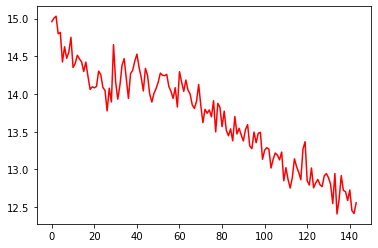

In [14]:
#구한 미래 데이터로 그래프 그려보기
from matplotlib import pyplot as plt

#그래프 그리기위해 리스트로 변경
pred_price2=pred_price.flatten().tolist()


df_list=pd.DataFrame(pred_price2,columns=['value'])
plt.plot(df_list,color='r')

In [15]:
#예측한 값 csv 파일로 뽑기

ka=pd.DataFrame(pred_price2,columns=['value'])
ka.to_csv("1day_pred_ONTUNE_result.csv")
